# Datasets comparison between CAMS and GOME-2 (L3)

## Imports and supporting functions

In [3]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3
import wget # Important for GOME-2
import subprocess # Important for GOME-2
import bs4 # Important for GOME-2 L2
import h5py # Important for GOME-2 L2
from zipfile import ZipFile # Important for GOME-2 L3 (TEMIS)

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [4]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_gome.ipynb

In [5]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [6]:
# Define component (NO2)
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Define sensor
sensor = 'gome'
sensor_type = 'L3'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2018-01-01'
end_date = '2018-12-31'

# Define extent
area_name = 'Europe'
lon_min = -25
lon_max = 45
lat_min = 30
lat_max = 70

# Define resolution (Unique: 0.25x.0.25)
lat_res = 0.25
lon_res = 0.25

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

In [7]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [8]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In months: ('2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12')
SEARCH BOUNDING BOX
Latitudes: from 30 to 70
Longitudes: from -25 to 45


## 2. Model data

### Download and read data as xarray

In [9]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name, 
                                               model_level = 'Single', CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [10]:
model_ds, dates, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 94, time: 12)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
    surface     float64 ...
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -25.0 -24.25 -23.5 ... 43.25 44.0 44.75
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-13T11:01 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [11]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


### Get CAMS levels (total or tropospheric)

In [12]:
model_ds = CAMS_get_levels_data(model_ds, model_product_name, model_levels_df,
                                column_type, lat_min, lat_max, lon_min, lon_max)
model_ds

The model total columns will be directly compared to the tropospheric sensor columns.


<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 94, time: 12)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
    surface     float64 0.0
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -25.0 -24.25 -23.5 ... 43.25 44.0 44.75
    valid_time  (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
Data variables:
    component   (time, latitude, longitude) float32 1.136e+15 ... 1.217e+15
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-13T11:01 GRIB to CDM+CF via cfgrib-0.9.9...

## 3. Sensor data

### Download and read data as xarray

In [13]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

RESULTS
For 2018-01:
GOME_L3_NO2_COLUMN_METOP_A_201801.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201801.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_A_201801.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201801.asc.zip was downloaded.
For 2018-02:
GOME_L3_NO2_COLUMN_METOP_A_201802.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201802.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_A_201802.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201802.asc.zip was downloaded.
For 2018-03:
GOME_L3_NO2_COLUMN_METOP_A_201803.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201803.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_A_201803.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201803.asc.zip was downloaded.
For 2018-04:
GOME_L3_NO2_COLUMN_METOP_A_201804.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201804.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_A_201804.asc.zip was downloaded.
GOME_L3_NO2_COLUMN_METOP_B_201804.asc.zip was downloaded.
For 2018-05:

In [14]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, 
                              dates, satellites, lat_res, lon_res)
sensor_ds

<xarray.Dataset>
Dimensions:        (latitude: 720, longitude: 1440, time: 12)
Coordinates:
  * time           (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
  * latitude       (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude      (longitude) float64 -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    sensor_column  (time, latitude, longitude) float64 nan nan nan ... nan nan

## 4. Match data

In [15]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR MONTH: 2018-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-03
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-04
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-05
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-06
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-07
The model dataset does not contain levels data.
The model dataset will be merged with the sensor da

latitude  longitude       time  sensor_column  model_column
0        29.875    -25.125 2018-01-01   7.000000e+13  1.135508e+15
1        29.875    -24.875 2018-01-01  -1.600000e+14  1.135508e+15
2        29.875    -24.625 2018-01-01  -2.200000e+14  1.154360e+15
3        29.875    -24.375 2018-01-01  -2.000000e+13  1.154360e+15
4        29.875    -24.125 2018-01-01   2.300000e+14  1.154360e+15
...         ...        ...        ...            ...           ...
45236    69.875     43.875 2018-12-01            NaN  1.228815e+15
45237    69.875     44.125 2018-12-01            NaN  1.228815e+15
45238    69.875     44.375 2018-12-01            NaN  1.217164e+15
45239    69.875     44.625 2018-12-01            NaN  1.217164e+15
45240    69.875     44.875 2018-12-01            NaN  1.217164e+15

[542892 rows x 5 columns]

## 5. Merge data and calculate difference

In [16]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column    difference  \
latitude longitude time                                                    
29.875   -25.125   2018-01-01  1.135508e+15   7.000000e+13 -1.065508e+15   
         -24.875   2018-01-01  1.135508e+15  -1.600000e+14 -1.295508e+15   
         -24.625   2018-01-01  1.154360e+15  -2.200000e+14 -1.374360e+15   
         -24.375   2018-01-01  1.154360e+15  -2.000000e+13 -1.174360e+15   
         -24.125   2018-01-01  1.154360e+15   2.300000e+14 -9.243602e+14   
...                                     ...            ...           ...   
69.875    43.875   2018-12-01  1.228815e+15            NaN           NaN   
          44.125   2018-12-01  1.228815e+15            NaN           NaN   
          44.375   2018-12-01  1.217164e+15            NaN           NaN   
          44.625   2018-12-01  1.217164e+15            NaN           NaN   
          44.875   2018-12-01  1.217164e+15            NaN           NaN   

                               relative_difference  
latitude longitude time                             
29.875   -25.125   2018-01-01            15.221547  
         -24.875   2018-01-01            -8.096927  
         -24.625   2018-01-01            -6.247092  
         -24.375   2018-01-01           -58.718012  
         -24.125   2018-01-01             4.018958  
...                                            ...  
69.875    43.875   2018-12-01                  NaN  
          44.125   2018-12-01                  NaN  
          44.375   2018-12-01                  NaN  
          44.625   2018-12-01                  NaN  
          44.875   2018-12-01                  NaN  

[542892 rows x 4 columns]

In [17]:
descr_stats_table = merge_df.describe()
descr_stats_table

model_column  sensor_column    difference  relative_difference
count  5.428920e+05   4.862860e+05  4.862860e+05         4.862860e+05
mean   2.917639e+15   1.489967e+15 -1.465057e+15                  inf
std    1.601486e+15   1.641497e+15  1.283742e+15                  NaN
min    4.570347e+14  -8.620000e+15 -1.539660e+16        -6.701922e+02
25%    1.702274e+15   4.100000e+14 -1.924591e+15         2.794589e-01
50%    2.580955e+15   1.080000e+15 -1.334398e+15         1.012922e+00
75%    3.686065e+15   2.130000e+15 -8.712350e+14         2.475031e+00
max    1.885660e+16   2.947000e+16  2.226056e+16                  inf

## 6. Show comparison plots

### Select plot dates

In [18]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2018-01' '2018-02' '2018-03' '2018-04' '2018-05' '2018-06' '2018-07'
 '2018-08' '2018-09' '2018-10' '2018-11' '2018-12']


### Select plot extent

In [19]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-25, 30), (45, 70))


### Compare CAMS and GOME-2 total columns

Frame length between -25 and 45 should be one of these options: [1, 2, 5, 7, 10, 14, 35, 70]
Frame length between 30 and 70 should be one of these options: [1, 2, 4, 5, 8, 10, 20, 40]


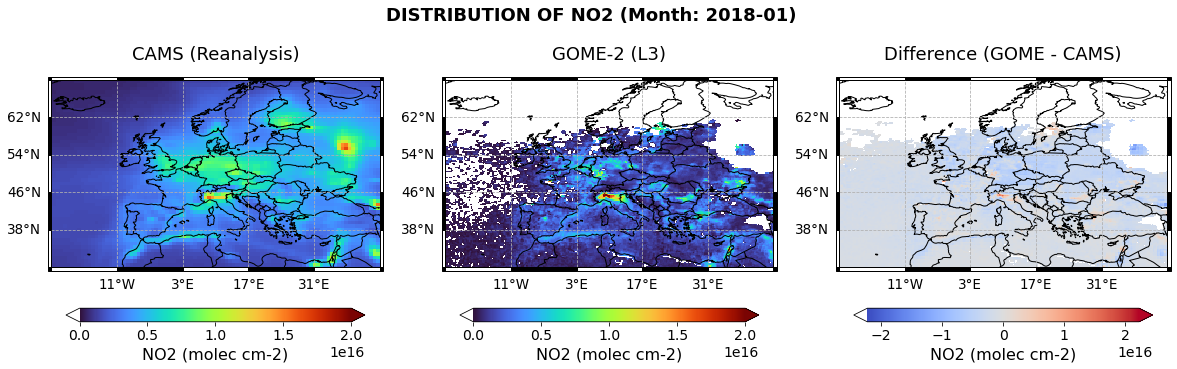

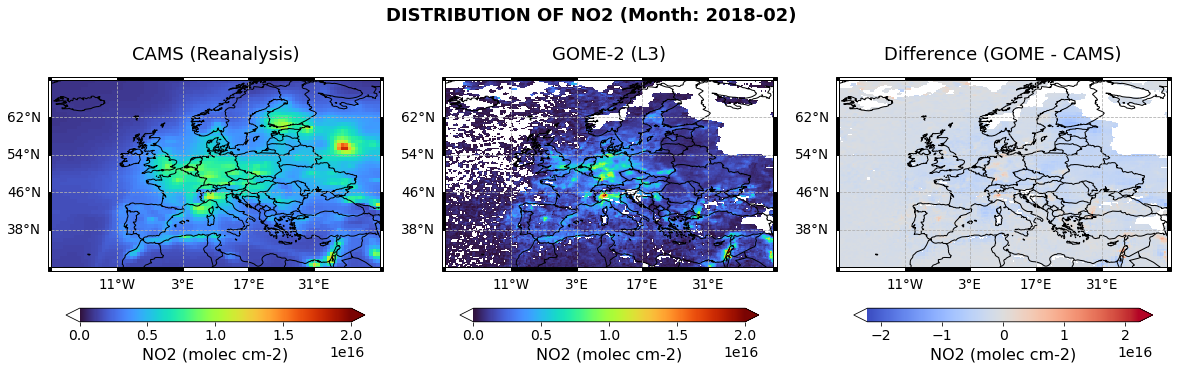

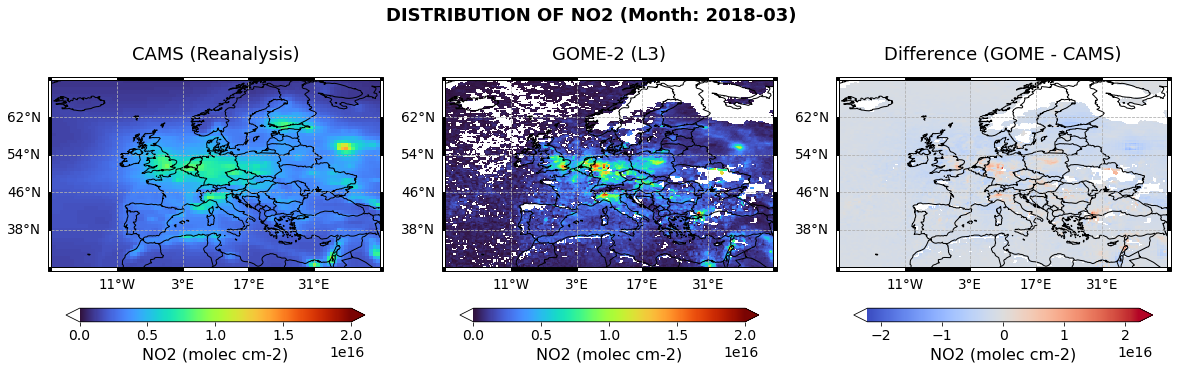

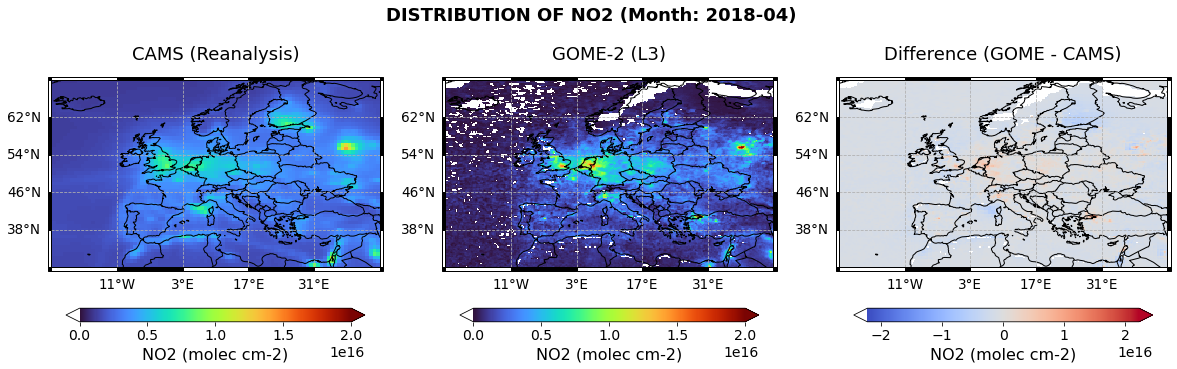

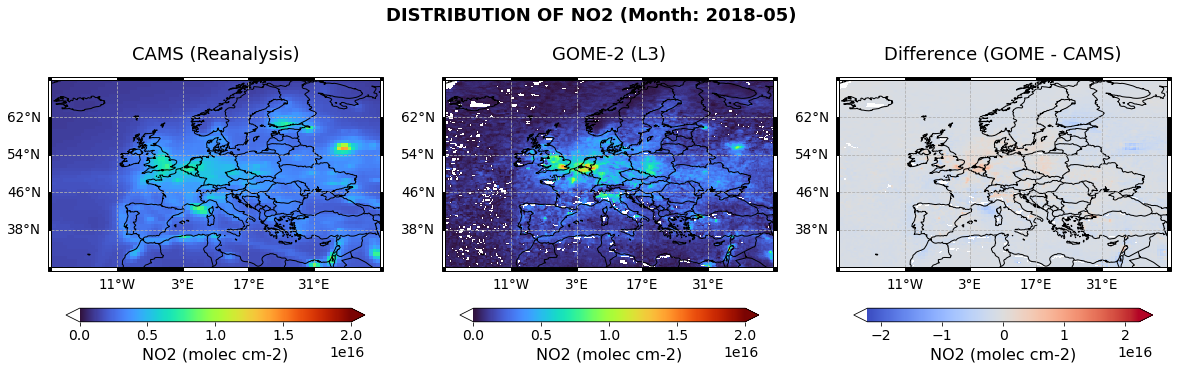

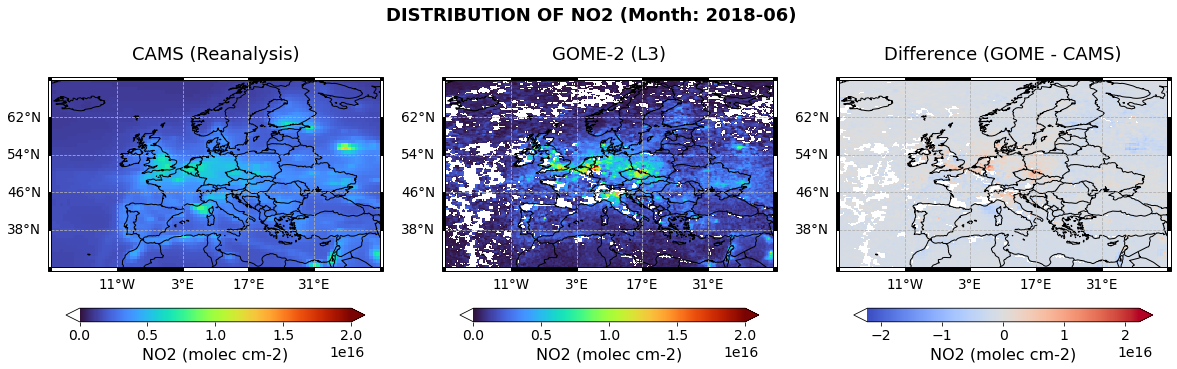

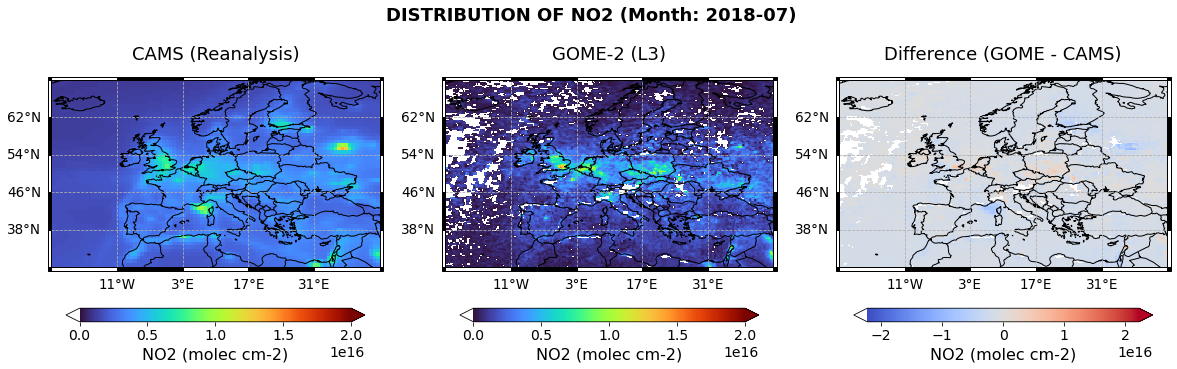

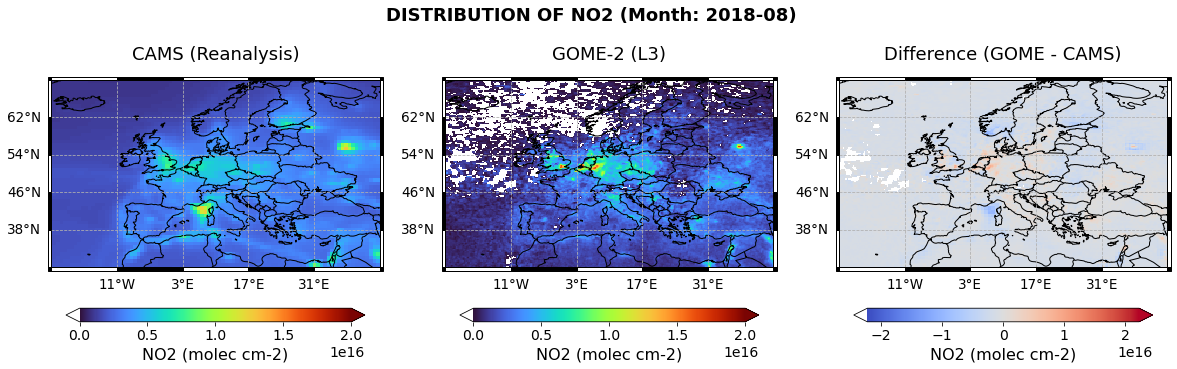

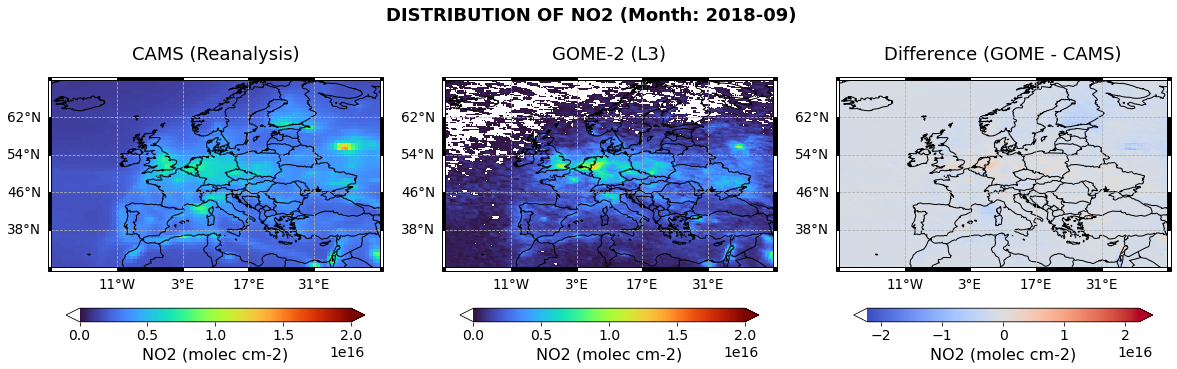

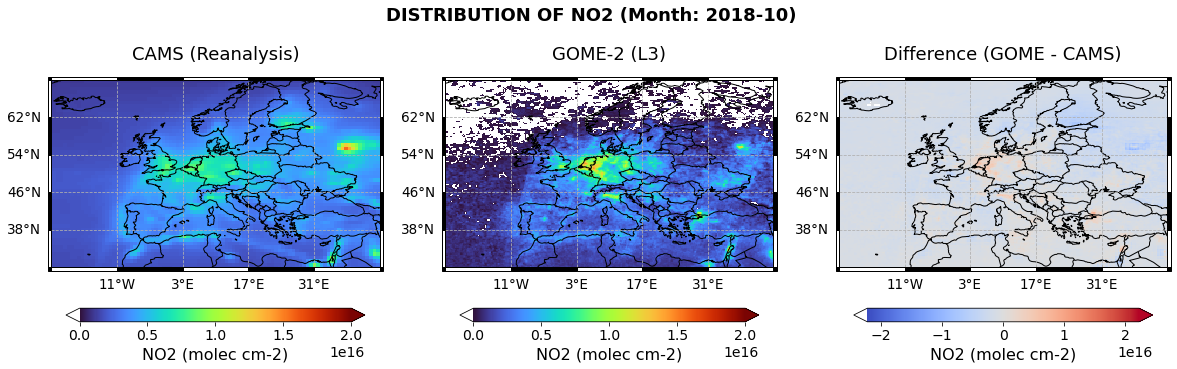

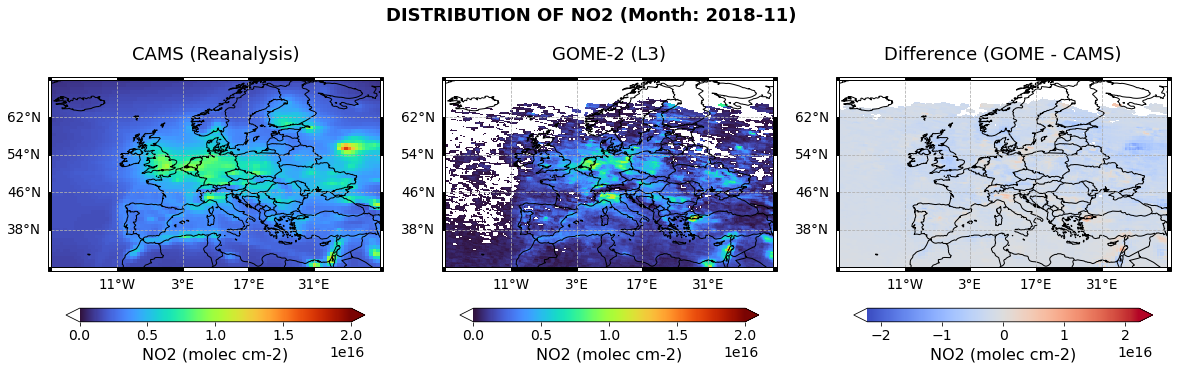

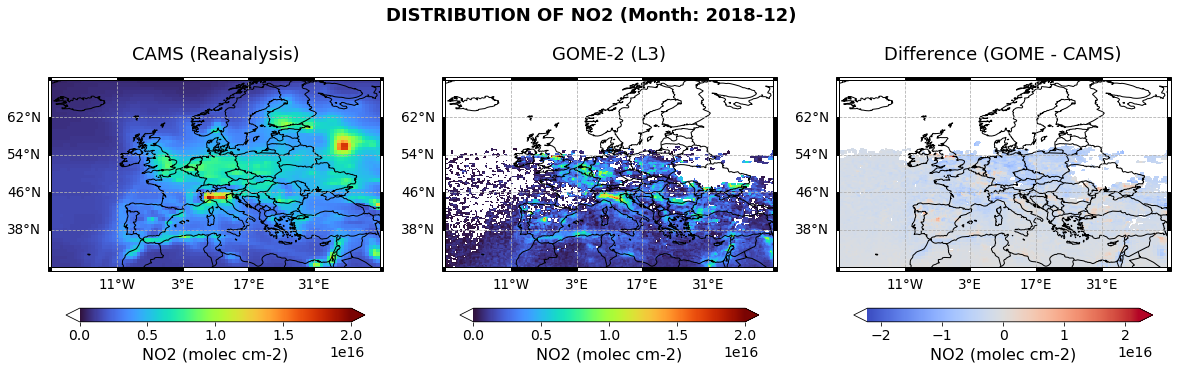

In [20]:
# Choose distribution (aggregated, individual, seasonal or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'manual'
vmin_manual = 0
vmax_manual = 2*10**16

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['turbo', 'turbo', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 14
height_lat = 8

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific coordinates

model_column  \
region   lat_search lon_search latitude longitude time                       
Milan    45.47      9.17       45.375   9.125     2018-01-01  9.770686e+15   
                                                  2018-02-01  9.984277e+15   
                                                  2018-03-01  7.137205e+15   
                                                  2018-04-01  4.380449e+15   
                                                  2018-05-01  4.839213e+15   
                                                  2018-06-01  4.935786e+15   
                                                  2018-07-01  4.901730e+15   
                                                  2018-08-01  4.910341e+15   
                                                  2018-09-01  5.491628e+15   
                                                  2018-10-01  6.372129e+15   
                                                  2018-11-01  6.940284e+15   
                                                  2018-12-01  1.270111e+16   
Istanbul 41.00      28.90      40.875   28.875    2018-01-01  6.177232e+15   
                                                  2018-02-01  4.555640e+15   
                                                  2018-03-01  4.562368e+15   
                                                  2018-04-01  4.309384e+15   
                                                  2018-05-01  3.665883e+15   
                                                  2018-06-01  3.799547e+15   
                                                  2018-07-01  3.956026e+15   
                                                  2018-08-01  3.189048e+15   
                                                  2018-09-01  3.646567e+15   
                                                  2018-10-01  4.476840e+15   
                                                  2018-11-01  4.890612e+15   
                                                  2018-12-01  6.226481e+15   

                                                              sensor_column  \
region   lat_search lon_search latitude longitude time                        
Milan    45.47      9.17       45.375   9.125     2018-01-01   2.372000e+16   
                                                  2018-02-01   1.971000e+16   
                                                  2018-03-01   1.540000e+16   
                                                  2018-04-01   1.106000e+16   
                                                  2018-05-01   8.190000e+15   
                                                  2018-06-01   7.840000e+15   
                                                  2018-07-01   5.620000e+15   
                                                  2018-08-01   4.540000e+15   
                                                  2018-09-01   5.690000e+15   
                                                  2018-10-01   1.064000e+16   
                                                  2018-11-01   8.870000e+15   
                                                  2018-12-01   1.143000e+16   
Istanbul 41.00      28.90      40.875   28.875    2018-01-01   7.830000e+15   
                                                  2018-02-01   1.059000e+16   
                                                  2018-03-01   6.860000e+15   
                                                  2018-04-01   1.395000e+16   
                                                  2018-05-01   9.010000e+15   
                                                  2018-06-01   5.500000e+15   
                                                  2018-07-01   7.270000e+15   
                                                  2018-08-01   6.270000e+15   
                                                  2018-09-01   7.870000e+15   
                                                  2018-10-01   1.082000e+16   
                                                  2018-11-01   1.046000e+16   
                                                  2018-12-

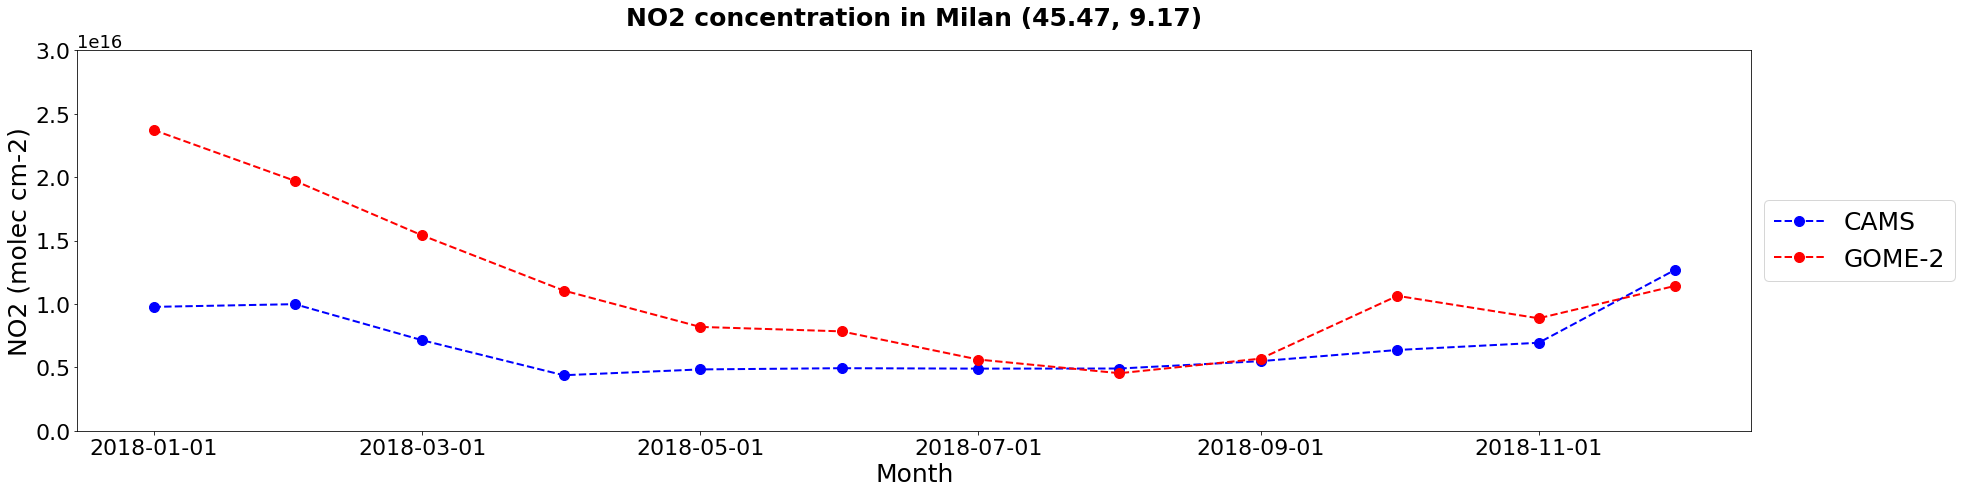

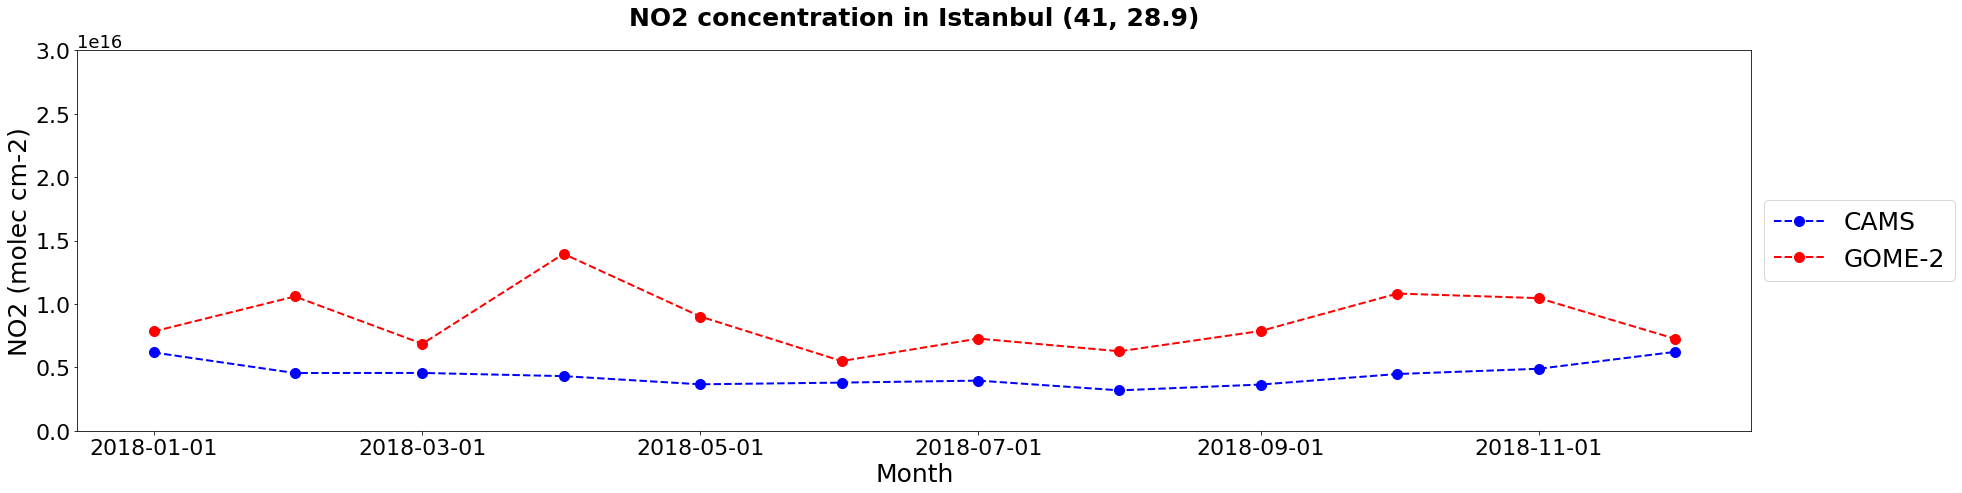

In [21]:
regions_names = ('Milan', 'Istanbul')
coords_list = (45.47, 9.17,
               41, 28.9
              )
ymin = 0
ymax = 3*10**16
xticks = plot_dates[0::2]

timeseries_table = timeseries(merge_df.dropna(), component_nom, sensor, sensor_type, model, 
                              plot_dates, units, ymin, ymax, xticks, regions_names, coords_list)
timeseries_table

## 8. Monthly annual cycle

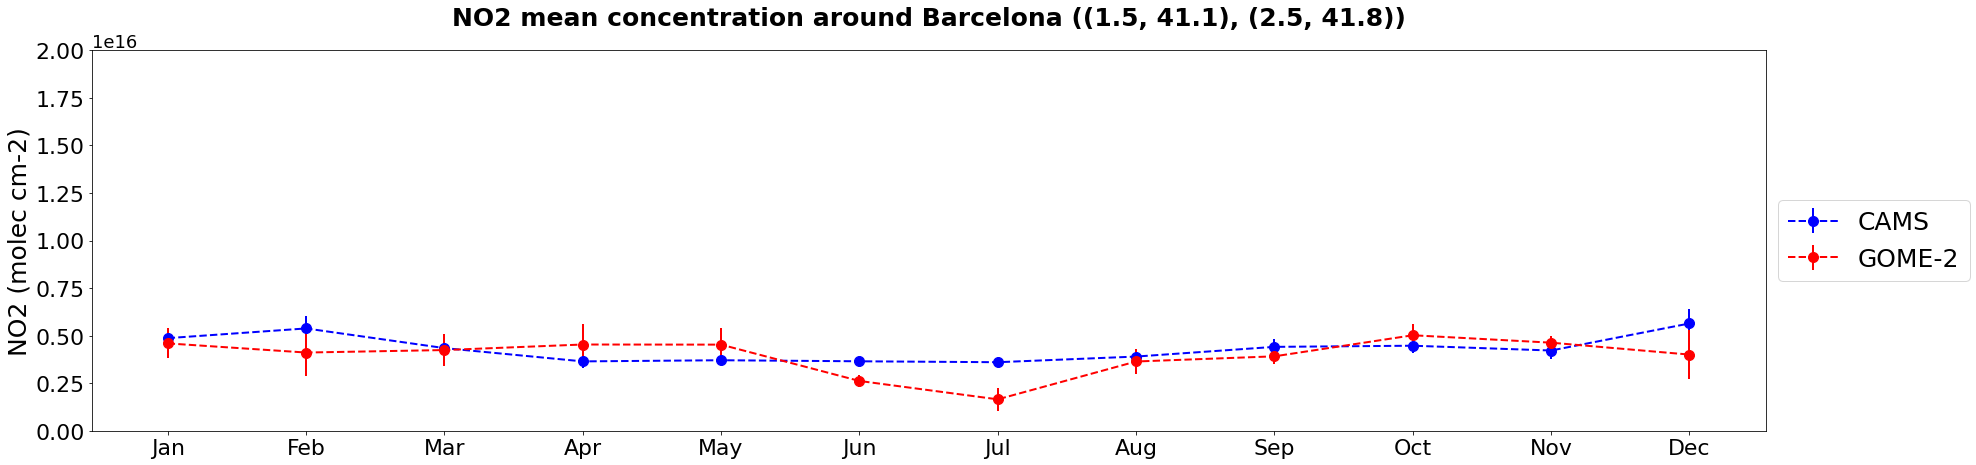

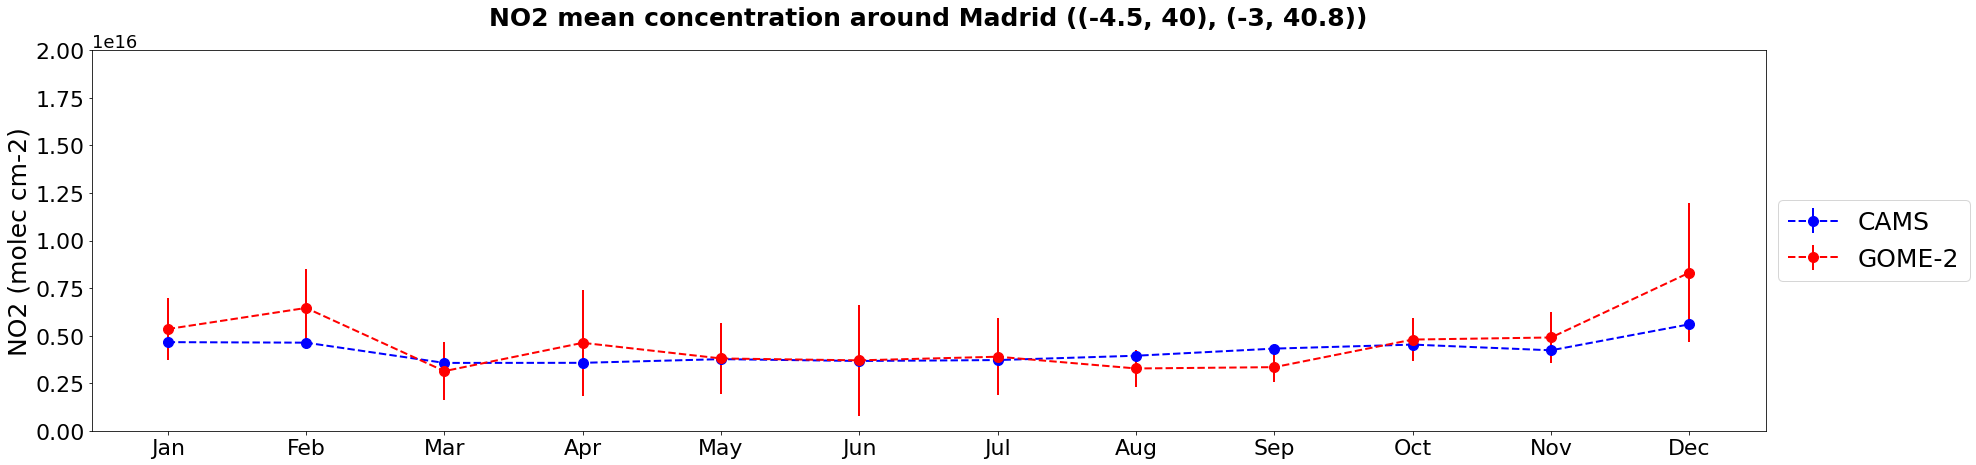

location  month    model mean     model std   sensor mean    sensor std
0   Barcelona      1  4.869808e+15  4.543781e+14  4.594167e+15  7.893318e+14
1   Barcelona      2  5.380016e+15  6.356798e+14  4.113333e+15  1.227031e+15
2   Barcelona      3  4.346822e+15  3.201322e+14  4.244167e+15  8.630123e+14
3   Barcelona      4  3.648539e+15  3.726587e+14  4.535000e+15  1.082644e+15
4   Barcelona      5  3.708531e+15  2.706397e+14  4.529167e+15  8.812023e+14
5   Barcelona      6  3.653504e+15  1.289898e+14  2.620000e+15  3.158322e+14
6   Barcelona      7  3.605252e+15  2.328185e+14  1.653636e+15  6.058923e+14
7   Barcelona      8  3.902026e+15  3.334439e+14  3.642500e+15  6.315511e+14
8   Barcelona      9  4.411828e+15  3.946283e+14  3.914167e+15  4.018018e+14
9   Barcelona     10  4.471599e+15  3.847742e+14  5.021667e+15  6.146667e+14
10  Barcelona     11  4.219640e+15  4.356316e+14  4.631667e+15  3.539089e+14
11  Barcelona     12  5.641878e+15  7.843033e+14  4.005833e+15  1.278212e+15
0      Madrid      1  4.660388e+15  2.479632e+14  5.347222e+15  1.632868e+15
1      Madrid      2  4.632427e+15  2.006609e+14  6.457222e+15  2.035132e+15
2      Madrid      3  3.568004e+15  1.276393e+14  3.136111e+15  1.517568e+15
3      Madrid      4  3.572462e+15  2.039924e+13  4.623889e+15  2.798552e+15
4      Madrid      5  3.765639e+15  4.267261e+13  3.802222e+15  1.845132e+15
5      Madrid      6  3.669876e+15  4.508372e+13  3.702778e+15  2.925406e+15
6      Madrid      7  3.718007e+15  2.781997e+13  3.894444e+15  2.011114e+15
7      Madrid      8  3.945765e+15  8.081594e+13  3.276111e+15  9.495766e+14
8      Madrid      9  4.320123e+15  8.760220e+13  3.345556e+15  7.885670e+14
9      Madrid     10  4.531168e+15  1.183428e+13  4.795556e+15  1.152053e+15
10     Madrid     11  4.230860e+15  9.455598e+13  4.905000e+15  1.343613e+15
11     Madrid     12  5.598144e+15  6.077518e+14  8.315556e+15  3.648916e+15

In [22]:
regions_names = ('Barcelona', 'Madrid')
bbox_list = (41.1, 41.8, 1.5, 2.5,
             40, 40.8, -4.5, -3)
ymin = 0
ymax = 2*10**16

monthly_annual_cycle_table = monthly_annual_cycle(merge_df.dropna(), component_nom, sensor, model, units, 
                                                  ymin, ymax, regions_names, bbox_list)
monthly_annual_cycle_table

## 9. Trends

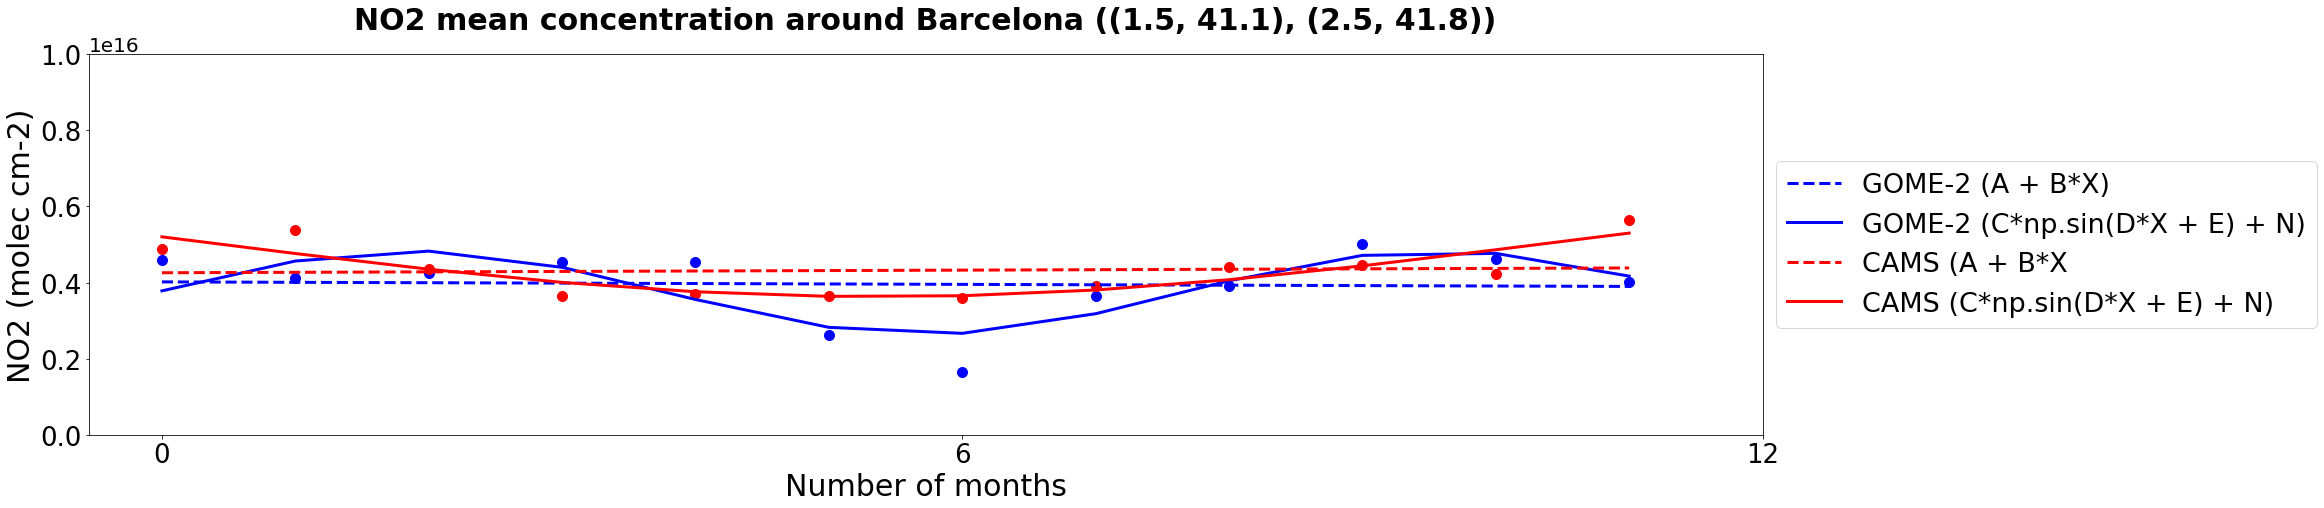

Sensor data at Madrid cannot be fitted with a sinusoidal model to account for the seasonality, consider working with a larger dataset.
Model data at Madrid cannot be fitted with a sinusoidal model to account for the seasonality, consider working with a larger dataset.


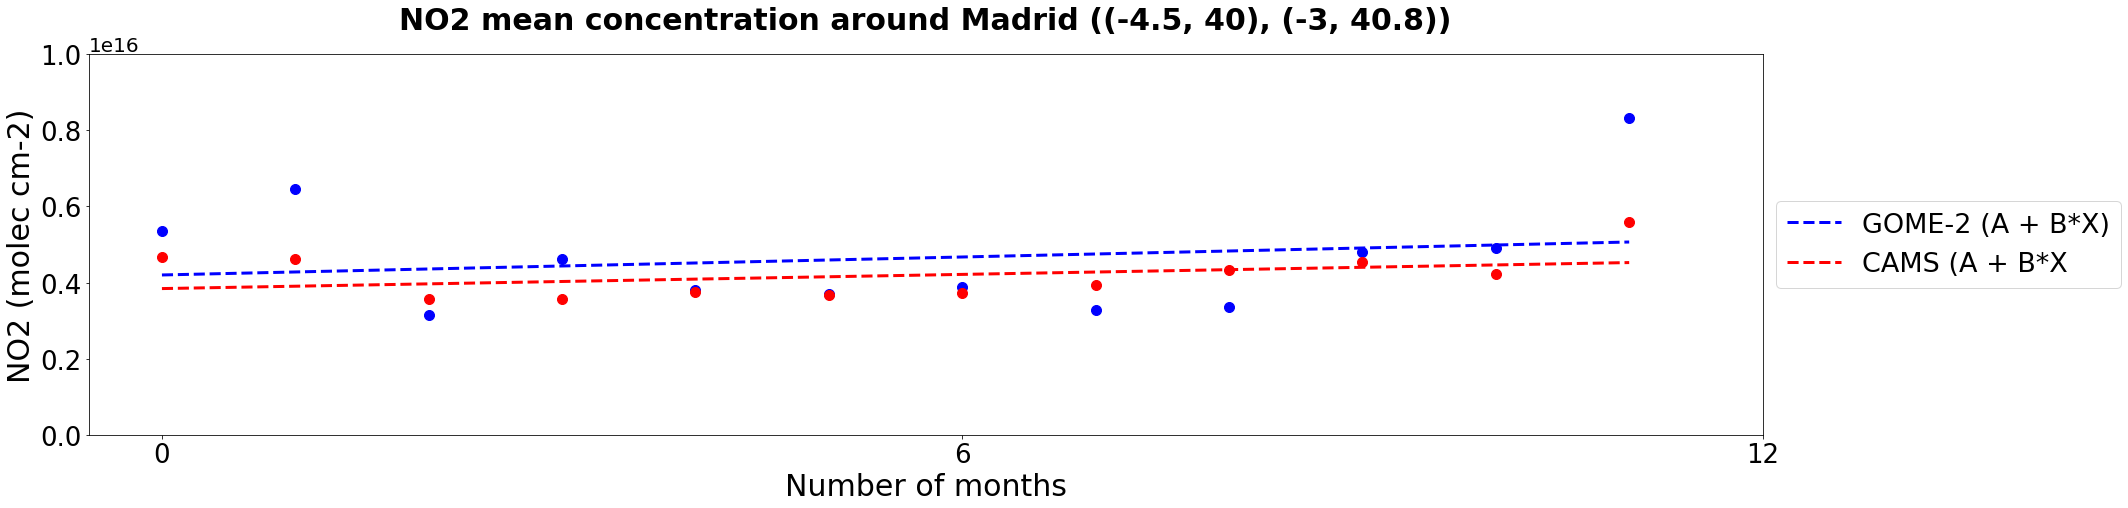

Location  Source  Rate (molec cm-2 y-1)  Rate (% y-1)             A  \
0  Barcelona  Sensor          -1.298474e+14     -3.231411  4.018289e+15   
1  Barcelona   Model           1.372653e+14      3.223168  4.258707e+15   
0     Madrid  Sensor           9.448718e+14     22.494773  4.200406e+15   
1     Madrid   Model           7.456016e+14     19.403210  3.842671e+15   

              B             C         D         E             N  Linear R2  \
0 -1.082062e+13 -1.097494e+15  0.815932 -3.098782  3.735853e+15   0.001681   
1  1.143877e+13 -1.395875e+15  0.315418 -0.128204  5.023819e+15   0.003619   
0  7.873932e+13           NaN       NaN       NaN           NaN   0.034988   
1  6.213346e+13           NaN       NaN       NaN           NaN   0.136792   

    Linear RMSE    Linear MSE  Sinusoidal R2  Sinusoidal RMSE  Sinusoidal MSE  
0  9.102397e+14  8.285364e+29       0.637984     5.481316e+14    3.004482e+29  
1  6.551900e+14  4.292739e+29       0.753293     3.260210e+14    1.062897e+29  
0  1.427507e+15  2.037777e+30            NaN              NaN             NaN  
1  5.388033e+14  2.903090e+29            NaN              NaN             NaN

In [23]:
regions_names = ('Barcelona', 'Madrid')
bbox_list = (41.1, 41.8, 1.5, 2.5,
             40, 40.8, -4.5, -3
            )
ymin = 0
ymax = 1*10**16
sensor_break_date = None # Date as a string or None
model_break_date = None # Date as a string or None

trends_table = trends(merge_df.dropna(), component_nom, sensor, model, units, ymin, ymax, 
                      plot_dates, regions_names, bbox_list, sensor_break_date, model_break_date)
trends_table

## 10. Scatter plots by bbox

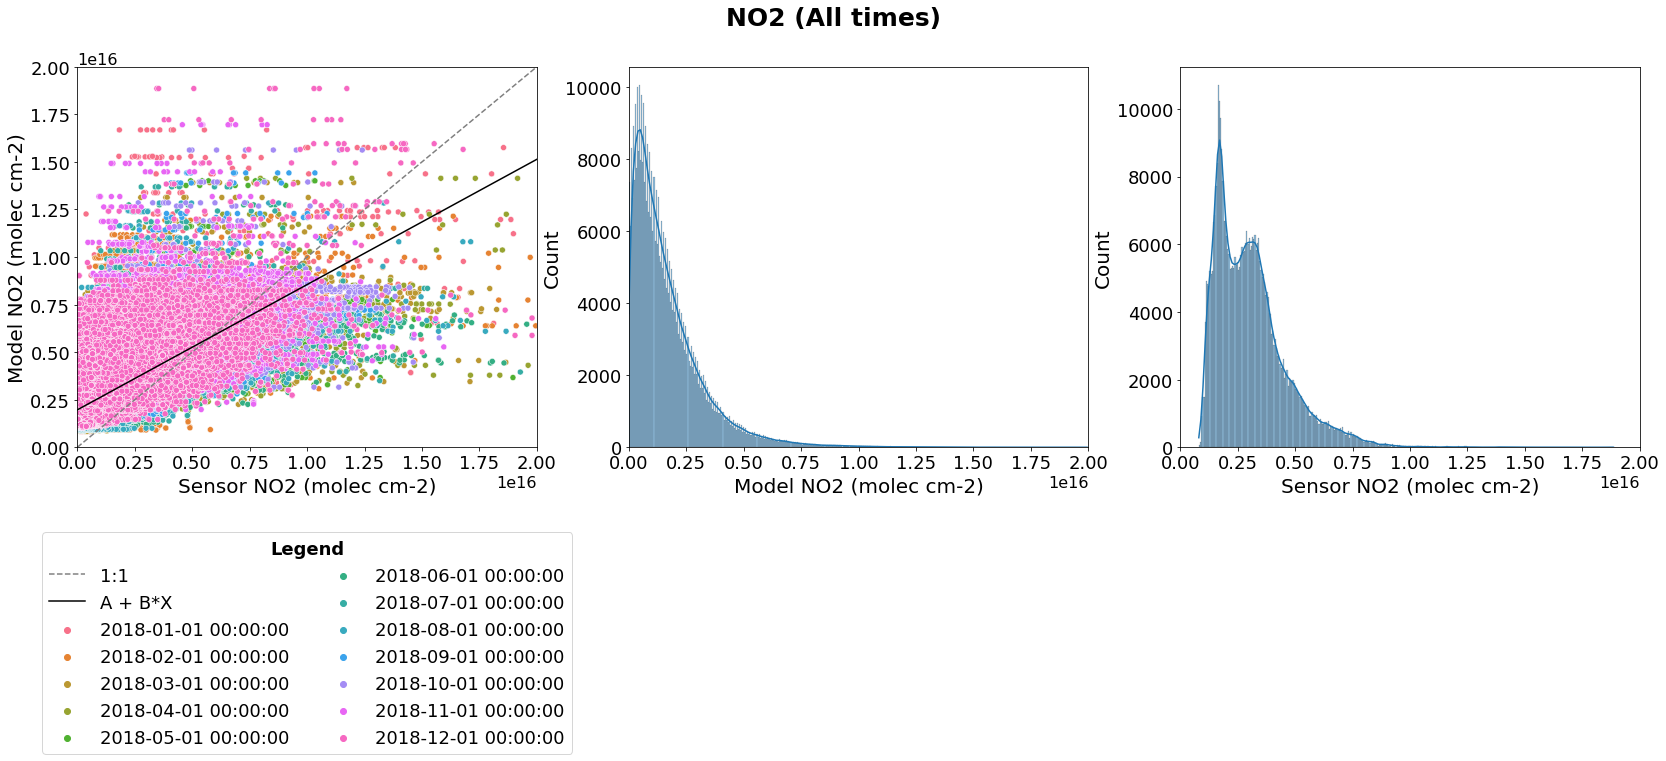

Period               Location  \
0  [2018-01-01T00:00:00.000000000, 2018-02-01T00:...  ((-25, 30), (45, 70))   

          A             B        R2          RMSE           MSE  
0  0.658438  1.967945e+15  0.456271  1.149990e+15  1.322478e+30

In [24]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 0
lim_max = 2*10**16

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 11. Scatter plots by season

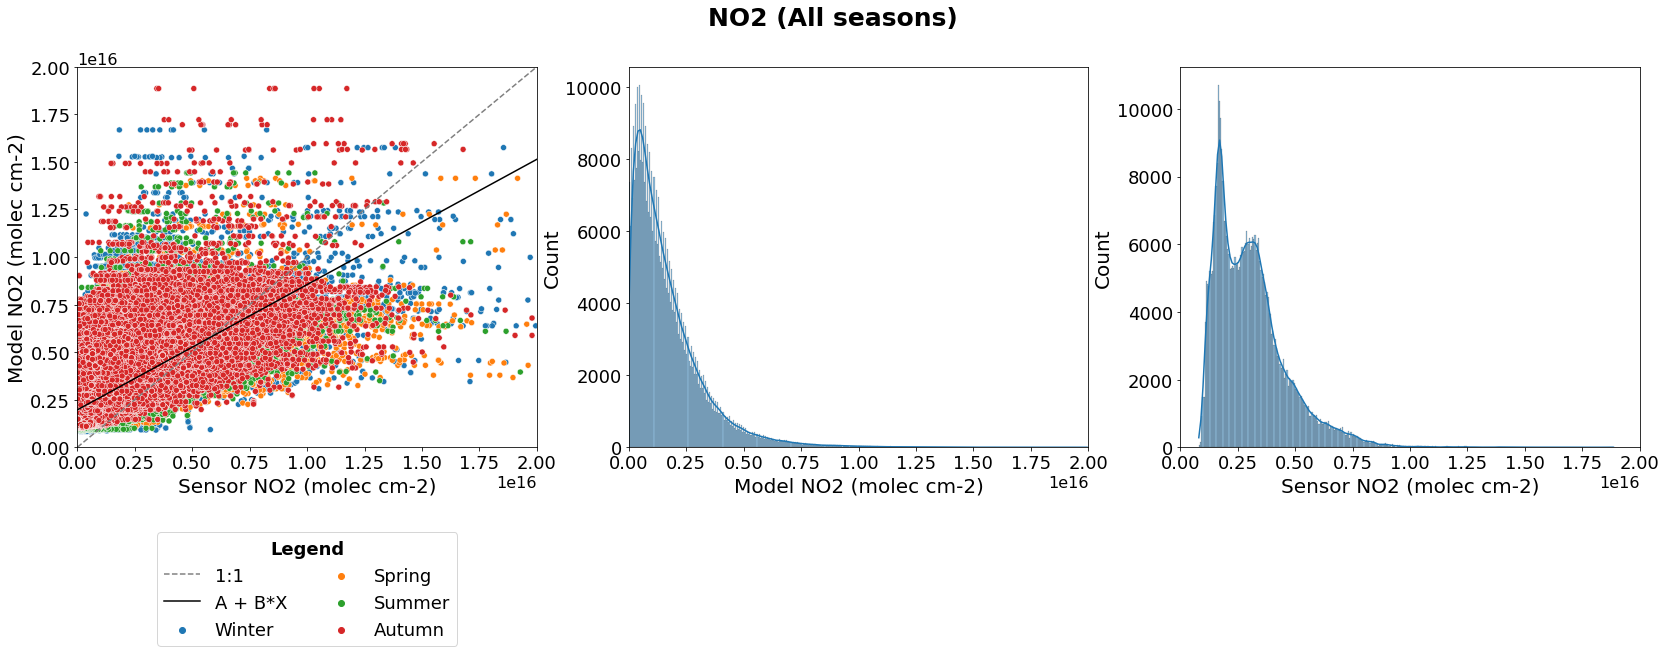

Period               Location         A  \
0  [Autumn, Spring, Summer, Winter]  ((-25, 30), (45, 70))  0.658438   

              B        R2          RMSE           MSE  
0  1.967945e+15  0.456271  1.149990e+15  1.322478e+30

In [25]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 0
lim_max = 2*10**16

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)
summary

## 12. Scatter plots by country (Google API required!)

In [26]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['China', 'India', 'Vietnam']

lim_min = None
lim_max = None

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
summary
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['China', 'India', 'Vietnam']\n\nlim_min = None\nlim_max = None\n\nsummary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\nsummary\n"